I ran this notebook on Google Colab. Cell's output are the one obtained there

## Exercise 1

Create a vectorized version of log and exp math function for 1D array A = [2, 5, 10, 3, 8]

Results should be: 
+ [0.6931472 1.609438  2.3025851 1.0986123 2.0794415]
+ [7.3890562e+00 1.4841316e+02 2.2026465e+04 2.0085537e+01 2.9809580e+03]

In [ ]:
import numpy as np
from numba import vectorize, int64, float32

A = np.array([2, 5, 10, 3, 8], dtype='float32')

@vectorize([float32(float32)], target='parallel', fastmath=True) 
def vec_log(x):
    return np.log(x)

@vectorize([float32(float32)], target='parallel', fastmath=True) 
def vec_exp(x):
    return np.exp(x)

print(vec_log(A))
print(vec_exp(A))

[0.6931472 1.609438  2.3025851 1.0986123 2.0794415]
[7.3890562e+00 1.4841316e+02 2.2026465e+04 2.0085537e+01 2.9809580e+03]


## Exercise 2
Compute the value of a Gaussian probability density function at $x$ with $mean = 1$, $\sigma = 1$, lower and upper bound in $(-3, 3)$ and $size = 100000$

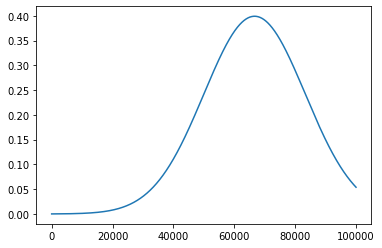

In [ ]:
import numpy as np
from numba import vectorize, float32, jit, cuda
import matplotlib.pyplot as plt
@vectorize([float32(float32)], target='parallel', fastmath=True) 
def vec_gaus(x):
    mean = 1.
    sigma = 1.
    return 1. / np.sqrt(2 * np.pi * sigma**2)* np.exp(- ((x - mean) / sigma)**2 / 2)

N = 100000
mesh = np.linspace(-3, 3, N, dtype='float32')
vec_gaus(mesh)
plt.plot(vec_gaus(mesh))
plt.show()

## Exercise 3

Create a "zero suppression" function. A common operation when working with waveforms is to force all samples values below a certain absolute magnitude to be zero, as a way to eliminate low amplitude noise. 
Plot the data before and after the application of the zero_suppress function.

$thresold = 15$

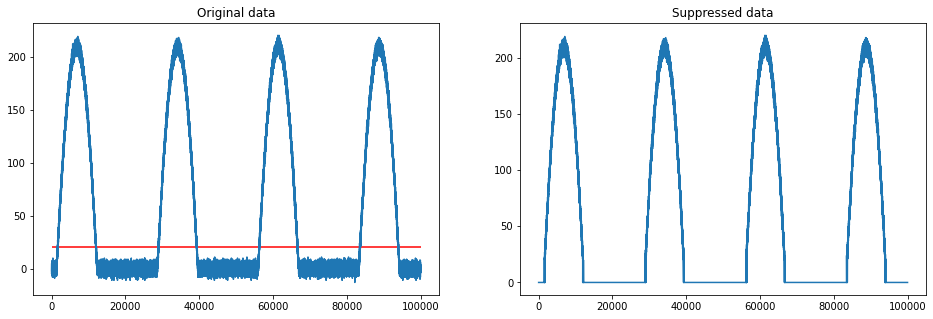

In [ ]:
%matplotlib inline
from matplotlib import pyplot as plt

n = 100000
noise = np.random.normal(size=n) * 3
pulses = np.maximum(np.sin(np.arange(n) / (n / 23)) - 0.3, 0.0)
data = ((pulses * 300) + noise).astype(np.int16)

@vectorize([float32(float32, float32)], target='parallel', fastmath=True) 
def vec_supp(x, thresh):
    if x < thresh:
        return 0
    else: return x

fig, ax = plt.subplots(1,2, figsize = (16,5))
ax[0].hlines(20, 0, 100000, color = 'red')


ax[0].plot(data)
ax[0].set_title('Original data')


data_supp = vec_supp(data, 20)
ax[1].plot(data_supp)
ax[1].set_title('Suppressed data')
plt.show()

## Exercise 4

Calculate the Sigmoid kernel between the matrix X and Y defined as below. The Sigmoid kernel is defined as:

$k(x,y) = \tanh(\alpha x^T y + c) $

In [ ]:
from numba import cuda
import numpy as np
import math 

cuda.select_device(0) #to be sure that I'm working on a GPU

X = np.random.rand(3,3).astype('float64')
Y = np.random.rand(3,3).astype('float64')
out = np.zeros((3,3), dtype='float64')

@cuda.jit
def sigmoid_kernel(x, y, result, a, c):    
    
    row, col = cuda.grid(2)
    
    if row < result.shape[0] and col < result.shape[1]:
        tmp = 0.
        for k in range(x.shape[0]):
            tmp += x[k, row] * y[k, col]
        
        result[row, col] = math.tanh(a * tmp + c)

        
sigmoid_kernel[(1,1),(3,3)](X, Y, out, 1., 1.)

print(out)

[[0.92977429 0.90570259 0.97016362]
 [0.97293651 0.97035847 0.99009157]
 [0.96740155 0.96049933 0.98825511]]


## Exercise 5

Create a kernel function similar to the ```double_kernel``` see during the lecture and create a new function that takes a 3 dimensional matrix as input calculating the $cos$ for each element and then returns the result. The shape of the matrix must be $256X256X256$. The matrix can be randomly generated

In [ ]:
from numba import cuda
import numpy as np
import math

cuda.select_device(0) #to be sure that I'm working on a GPU

# CUDA kernel
@cuda.jit
def cosine_kernel(io_array):
    x, y, z = cuda.grid(3)
    if x < io_array.shape[0] and y < io_array.shape[1] and z < io_array.shape[2]:
        io_array[x][y][z] = math.cos(io_array[x][y][z])

# Host code   
data = np.random.normal(size = (256, 256, 256))

# Configure the blocks
threadsperblock = (8, 8, 8) 
blockspergrid_x = int(math.ceil(data.shape[0] / threadsperblock[0]))
blockspergrid_y = int(math.ceil(data.shape[1] / threadsperblock[1]))
blockspergrid_z = int(math.ceil(data.shape[2] / threadsperblock[2]))
blockspergrid = (blockspergrid_x, blockspergrid_y, blockspergrid_z)

%timeit cosine_kernel[blockspergrid, threadsperblock](data)

print(data)

The slowest run took 5.24 times longer than the fastest. This could mean that an intermediate result is being cached.
1 loop, best of 3: 46.3 ms per loop
[[[0.67211696 0.69790168 0.74197531 ... 0.71888883 0.80221229 0.67033865]
  [0.66093639 0.83916992 0.85451111 ... 0.655305   0.65739034 0.75305611]
  [0.7765422  0.67593166 0.70784105 ... 0.81898494 0.71431234 0.66098347]
  ...
  [0.65748957 0.78141075 0.72162641 ... 0.8565564  0.84531472 0.65630638]
  [0.82761995 0.8020251  0.67297923 ... 0.857464   0.7092435  0.65468036]
  [0.67432426 0.73035488 0.74239074 ... 0.67299505 0.71151226 0.69680928]]

 [[0.6870642  0.75093941 0.65737956 ... 0.69307903 0.85556067 0.67155274]
  [0.65504068 0.69617249 0.85084434 ... 0.82434823 0.78782628 0.73396566]
  [0.65451327 0.80446223 0.67648866 ... 0.67774131 0.7616239  0.80176667]
  ...
  [0.85730868 0.78800777 0.6885612  ... 0.79638911 0.67917049 0.65465871]
  [0.81002517 0.6709673  0.8525709  ... 0.67357225 0.66354427 0.68482634]
  [0.7367211  0.75

## Exercise 6

Create a matrix multiplication kernel function, called ```matmul``` that takes as input two 2D matrices:
+ A of shape $24x12$
+ B of shape $12x22$
and that computes the multiplication and put the results into a third matrix C of shape $24x12$

A and B must be randomly generated and only int values are allowed.


In [ ]:
from __future__ import division
from numba import cuda
import numpy as np
import math

cuda.select_device(0) #to be sure that I'm working on a GPU

# complete the code
@cuda.jit
def matmul(A, B, C):
    row, col = cuda.grid(2)
    if row < C.shape[0] and col < C.shape[1]:
        tmp = 0.
        for k in range(A.shape[1]):
            tmp += A[row, k] * B[k, col]
        C[row, col] = tmp

# Initialize the data arrays
A = np.random.randint(100, size=(24, 12))
B = np.random.randint(100, size=(12, 22))

# Configure the blocks
threadsperblock = (24, 22)
blockspergrid_x = int(math.ceil(A.shape[0] / threadsperblock[0]))
blockspergrid_y = int(math.ceil(B.shape[0] / threadsperblock[1]))
blockspergrid = (blockspergrid_x, blockspergrid_y)

C = np.zeros((24,22))
matmul[blockspergrid, threadsperblock](A, B, C)

print(C)

[[34734. 41659. 41151. 41338. 35511. 37395. 23582. 34329. 41196. 36234.
  37014. 23888. 30202. 32926. 28950. 39582. 22303. 29255. 19804. 20742.
  29731. 30967.]
 [32536. 37027. 29291. 34797. 25852. 31919. 22616. 21715. 36252. 24722.
  32735. 21499. 27353. 22778. 28273. 32850. 17728. 27395. 22499. 25821.
  26667. 27566.]
 [35324. 44457. 35213. 37985. 35568. 38599. 28026. 25453. 43536. 33356.
  38267. 25227. 26597. 26866. 29415. 34998. 18500. 31035. 23845. 23195.
  29073. 29158.]
 [20312. 24483. 22407. 22732. 18407. 24224. 13981. 16310. 22177. 21639.
  22939. 13308. 17084. 17410. 18072. 24703. 16010. 17533. 12981. 12046.
  19834. 16213.]
 [33867. 42415. 34389. 41661. 30593. 37357. 26848. 28061. 42895. 32479.
  37339. 25544. 27661. 33978. 37069. 32962. 23335. 25376. 24492. 31321.
  32307. 37756.]
 [27672. 27889. 24944. 24772. 18955. 27344. 20014. 19092. 32071. 26104.
  22241. 17139. 22973. 22460. 24925. 24334. 17248. 25233. 19666. 21189.
  25005. 22336.]
 [23584. 26539. 25017. 25364. 1847